# Predicting sequences with CNN

Although convolutional neural networks are mostly used with images, they can also give good results with time series data!


#### 1. Read some time series data

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
df = pd.read_csv("./data/retail_sales.csv", index_col='date')

In [23]:
df['y'] = df['sales'].shift(-1)

#### 3. Preprocessing

Time series data usually has some trend, and this might make things difficult to predict. 

One way of dealing with trends is to take differences instead. 

We will also normalize the values so that everything stays between -1 and 1.


In [24]:
print("Use the .diff() method to take differences automatically")
df.diff().head()

Use the .diff() method to take differences automatically


,sales,y
date,,
2009-10-01,NaN,NaN
2009-11-01,756.0,60878.0
2009-12-01,60878.0,-85624.0
2010-01-01,-85624.0,-3618.0
2010-02-01,-3618.0,49797.0


In [25]:
df.diff().tail()

,sales,y
date,,
2015-05-01,24398.0,-14386.0
2015-06-01,-14386.0,9481.0
2015-07-01,9481.0,-1370.0
2015-08-01,-1370.0,-25423.0
2015-09-01,-25423.0,NaN


In [26]:
df = df.diff()

In [27]:
df.fillna(value=df['y'].mean(),axis=0, inplace=True)

In [28]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler(feature_range=(-1,1))

#### 4. Dividing between training and testing.

As the information is coming sequentially, it makes more sense to split between training and validation in the natural order it happens.

In [29]:
train_idx = int(0.8*len(df))
train, test = df.values[0:-train_idx], df.values[-train_idx:]

In [30]:
train = scl.fit_transform(train)
test = scl.transform(test)

In [31]:
X_train, y_train = train[:,0:-1], train[:,-1]
X_test, y_test = test[:,0:-1], test[:,-1]

The LSTM layer expects input as 
- **samples**: independent observations.
- **timesteps**: the same sample measured during different time steps. Here we have 1 sample = 1 time step.
- **features**: the usual attributes.


In [32]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [33]:
batch_size = 1
n_epochs = 100
neurons = 4

In [34]:
from keras.models import Sequential
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten
model = Sequential()

model.add(
    LSTM(neurons, 
               batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True)
         )
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [35]:
model.fit(X_train,y_train, epochs=n_epochs, batch_size=batch_size, verbose=0)

In [36]:
preds = model.predict(X_test, batch_size=batch_size)

In [37]:
X_test.shape

(57, 1, 1)

In [38]:
preds.shape

(57, 1)

In [39]:
reshaped_preds = scl.inverse_transform(np.hstack([X_test.reshape(X_test.shape[0],X_test.shape[2]),preds]))

In [40]:
reshaped_preds = np.concatenate([X_test.reshape(X_test.shape[0],1),preds], axis=1)

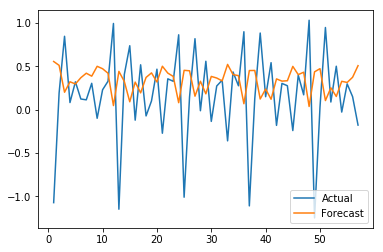

In [41]:
pd.DataFrame(data = reshaped_preds, columns = ['Actual','Forecast'], 
             index=range(1,train_idx+1)).plot()

In [43]:
from sklearn.metrics import mean_squared_error
mean_squared_error(reshaped_preds[:,0], reshaped_preds[:,1])

0.42141525229762816